In [1]:
import os
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, length, when, col, broadcast
from pyspark.sql.types import BooleanType, IntegerType, LongType, StringType, ArrayType, FloatType, StructType, StructField
import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader
import pandas as pd
import datetime

In [2]:
# setting constants
APP_NAME = "lera_app_new"
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = "-Dlog4j.configuration=file://{} -Dspark.hadoop.dfs.replication=1 -Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"\
    .format(LOG4J_PROP_FILE)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [3]:
# preparing configuration files from templates
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template\
    .stream(logfile=LOG_FILE)\
    .dump(LOG4J_PROP_FILE)

In [4]:
# run spark
spark = SparkSession\
    .builder\
    .appName(APP_NAME)\
    .master("k8s://https://10.32.7.103:6443")\
    .config("spark.driver.host", LOCAL_IP)\
    .config("spark.ui.port", "4040")\
    .config("spark.kubernetes.memoryOverheadFactor", "0.6")\
    .config("spark.driver.memory", "10g")\
    .config("spark.driver.bindAddress", "0.0.0.0")\
    .config("spark.executor.instances", "5")\
    .config("spark.executor.cores", '1')\
    .config("spark.executor.memory", "9g")\
    .config("spark.memory.fraction", "0.6")\
    .config("spark.memory.storageFraction", "0.5")\
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")\
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)\
    .config("spark.kubernetes.namespace", "vmyslenkova-337998")\
    .config("spark.kubernetes.driver.label.appname", APP_NAME)\
    .config("spark.kubernetes.executor.label.appname", APP_NAME)\
    .config("spark.kubernetes.container.image.pullPolicy", "Always")\
    .config("spark.kubernetes.container.image", "node03.st:5000/spark-executor:vmyslenkova-337998")\
    .config("spark.kubernetes.executor.deleteOnTermination", "true")\
    .config("spark.local.dir", "/tmp/spark")\
    .config("spark.kubernetes.driver.volumes.persistentVolumeClaim.nfs-home-storage.mount.path",'/home/jovyan/nfs-home')\
    .getOrCreate()

In [49]:
# .config("spark.kubernetes.executor.volumes.nfs.my_tom.mount.path",'/home/jovyan/nltk_data/corpora/wordnet')\
#.config("spark.kubernetes.executor.volumes.nfs.my_tom.mount.subPath",'/nfs/home/vmyslenkova-337998/nltk_data/corpora/wordnet')\
    

In [50]:
#spark.stop()

In [5]:
os.getcwd()

'/home/jovyan/nfs-home'

In [6]:
print("Web UI: {}".format(spark.sparkContext.uiWebUrl))
print("\nlog4j file: {}".format(LOG4J_PROP_FILE))
print("\ndriver log file: {}".format(LOG_FILE))

Web UI: http://10.128.251.38:4040

log4j file: /home/jovyan/nfs-home/conf/pyspark-log4j-lera_app_new.properties

driver log file: /home/jovyan/nfs-home/logs/pyspark-lera_app_new.log


In [7]:
df_1 = spark.read.json(f"hdfs:///home/vmyslenkova-337998/doc.json")

In [54]:
df_2 = spark.read.json(f"hdfs:///home/vmyslenkova-337998/doc1.json")

In [55]:
df_3 = spark.read.json(f"hdfs:///home/vmyslenkova-337998/doc2.json")

In [56]:
df_4 = spark.read.json(f"hdfs:///home/vmyslenkova-337998/doc3.json")

In [57]:
df_pyspark = df_1.union(df_2).union(df_3).union(df_4)

In [108]:
import pandas as pd

In [8]:
df = df_1.limit(1000).toPandas()

In [11]:
df.shape

(1000, 14)

In [13]:
import csv

In [14]:
df.to_csv('tst_pandas_file.csv', quoting=csv.QUOTE_ALL)

In [58]:
df_pyspark.show(1)

+--------+--------------------+--------------------+-----------+-------+----------+--------------------+------------------+-----+---------+-------------+-------+------------------+--------------------+
|abstract|          author_ids|        author_names|authorgroup|authors|   creator|         description|               eid|index|publisher|subject_areas|subtype|subtypedescription|               title|
+--------+--------------------+--------------------+-----------+-------+----------+--------------------+------------------+-----+---------+-------------+-------+------------------+--------------------+
|    null|7004218797;572081...|Yazdani, A.;Eftek...|       null|   null|Yazdani A.|The reliability o...|2-s2.0-84856856873|    0|     null|         null|     ar|              null|Variance decompos...|
+--------+--------------------+--------------------+-----------+-------+----------+--------------------+------------------+-----+---------+-------------+-------+------------------+------------

In [59]:
#spark.stop()

In [60]:
df_pyspark.count()

1604742

In [61]:
df_pyspark.printSchema()

root
 |-- abstract: string (nullable = true)
 |-- author_ids: string (nullable = true)
 |-- author_names: string (nullable = true)
 |-- authorgroup: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- description: string (nullable = true)
 |-- eid: string (nullable = true)
 |-- index: long (nullable = true)
 |-- publisher: string (nullable = true)
 |-- subject_areas: string (nullable = true)
 |-- subtype: string (nullable = true)
 |-- subtypedescription: string (nullable = true)
 |-- title: string (nullable = true)



In [62]:
from pyspark.sql.functions import split

In [63]:
df_pyspark.select(split(col('author_names'), ';').alias('author_names'), split(col('author_ids'), ';').alias('author_ids'), 'eid', 'description').show(10) #Не использовать без аргументов

+--------------------+--------------------+------------------+--------------------+
|        author_names|          author_ids|               eid|         description|
+--------------------+--------------------+------------------+--------------------+
|[Yazdani, A., Eft...|[7004218797, 5720...|2-s2.0-84856856873|The reliability o...|
|[Dehkordi, Massou...|[55667068800, 350...|2-s2.0-84855377268|In order to prote...|
|[Masmoudi, Ahmed,...|[7003830108, 2233...|2-s2.0-84986121023|Purpose – To purp...|
|[Hayat, T., Naz, ...|[8856998000, 5518...|2-s2.0-83255192281|The influence of ...|
|[Karimian, S. M.H...|[57197510735, 572...|2-s2.0-83255187977|In many particle-...|
|  [Dinarvand, Saeed]|       [24502768200]|2-s2.0-83255185870|This paper deals ...|
|[Sadeghian, Hamid...|[57217645052, 700...|2-s2.0-84455203936|This paper presen...|
|[Mobarhani, Amir,...|[27267855400, 568...|2-s2.0-84455192488|This paper propos...|
|[Movafaghpour, Mo...|[48861849300, 650...|2-s2.0-84455188696|In practical r

In [64]:
df_pyspark = df_pyspark.select(split(col('author_names'), ';').alias('author_names'), split(col('author_ids'), ';').alias('author_ids'), 'eid', 'description')

In [65]:
df_pyspark.show(10) 

+--------------------+--------------------+------------------+--------------------+
|        author_names|          author_ids|               eid|         description|
+--------------------+--------------------+------------------+--------------------+
|[Yazdani, A., Eft...|[7004218797, 5720...|2-s2.0-84856856873|The reliability o...|
|[Dehkordi, Massou...|[55667068800, 350...|2-s2.0-84855377268|In order to prote...|
|[Masmoudi, Ahmed,...|[7003830108, 2233...|2-s2.0-84986121023|Purpose – To purp...|
|[Hayat, T., Naz, ...|[8856998000, 5518...|2-s2.0-83255192281|The influence of ...|
|[Karimian, S. M.H...|[57197510735, 572...|2-s2.0-83255187977|In many particle-...|
|  [Dinarvand, Saeed]|       [24502768200]|2-s2.0-83255185870|This paper deals ...|
|[Sadeghian, Hamid...|[57217645052, 700...|2-s2.0-84455203936|This paper presen...|
|[Mobarhani, Amir,...|[27267855400, 568...|2-s2.0-84455192488|This paper propos...|
|[Movafaghpour, Mo...|[48861849300, 650...|2-s2.0-84455188696|In practical r

In [66]:
df_pyspark = df_pyspark.dropna()
df_pyspark = df_pyspark.dropDuplicates()
df_pyspark.count()

1500718

In [67]:
import re
import numpy as np
from pprint import pprint
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [68]:
from nltk.corpus import wordnet 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [69]:
import nltk

In [70]:
nltk.data.path.append('/home/jovyan/nfs-home/nltk_data')

In [71]:

from pyspark.sql import functions as F
from pyspark.sql import types as T

In [72]:
import nltk
from nltk.corpus import wordnet 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# convert to lower case, removing stop words, numbers / non-alphabetic characters, lemmatization.

#nltk.download('punkt',download_dir='/home/jovyan/nltk_data')
#nltk.download('wordnet', download_dir='/home/jovyan/nltk_data')
#nltk.download( 'stopwords', download_dir='/home/jovyan/nltk_data')
stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

def clear_files(text):
    text = text.lower()
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    #text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    new_text = ' '.join(text)
    return new_text

In [73]:
clear_udf = F.udf(f=lambda row: clear_files(row), returnType=T.StringType())

In [74]:
df_pyspark = df_pyspark.withColumn("description", clear_udf(F.col("description")))

In [75]:
os.getcwd()

'/home/jovyan/nfs-home'

In [76]:
df_pyspark.show(10)

+--------------------+--------------------+------------------+--------------------+
|        author_names|          author_ids|               eid|         description|
+--------------------+--------------------+------------------+--------------------+
|[Eslami, Mahdi, S...|[57220508856, 660...|2-s2.0-84865743085|common voice conv...|
|[Vaghasloo, Y. Al...|[6506911436, 3704...|2-s2.0-84863594441|paper size depend...|
|[Nejati, Mansour,...|[55359418700, 369...|2-s2.0-84856946260|digital subtracti...|
|[Asvadi, Alireza,...|[54897299500, 563...|2-s2.0-84855966716|present paper imp...|
| [Pashazadeh, Saeid]|       [24825064000]|2-s2.0-84855935997|pervasive healthc...|
|[Mohammadi, Masou...|[57638688100, 700...|2-s2.0-80055043811|machine vision sy...|
|[Tosco, Paolo, Ba...|[6602417528, 5596...|2-s2.0-80255123469|tool capable conv...|
|[Moradi, Mehdi, S...|[39061676800, 571...|2-s2.0-80054016788|aim study determi...|
|[Babaei, Ebrahim,...|[6506152637, 3701...|2-s2.0-80053955891|one switching 

In [77]:
def remove_punkt(text):
    text = re.sub(r"[0-9_-]", "", text)
    text = re.sub(r"\s+"," ",  text)
    text = text.strip()
    return text

remove_punkt_udf = F.udf(f=lambda row: remove_punkt(row), returnType=T.StringType())

In [78]:
df_pyspark = df_pyspark.withColumn("Description", remove_punkt_udf(F.col("Description")))
df_pyspark.show(10)

+--------------------+--------------------+------------------+--------------------+
|        author_names|          author_ids|               eid|         Description|
+--------------------+--------------------+------------------+--------------------+
|[Sun, Yunxin, Li,...|[57196185930, 571...|2-s2.0-85050450717|load forecasting ...|
|[Lv, Zhiming, Zha...|[57214310292, 571...|2-s2.0-85050375242|bayesian optimiza...|
|[Wang, Shenquan, ...|[48662854400, 571...|2-s2.0-85050313855|paper investigate...|
|[Lu, Fei, Zhang, ...|[25936561900, 564...|2-s2.0-85050290675|cloud computing e...|
|[Lu, Licheng, Ren...|[55779421300, 349...|2-s2.0-85049236111|paper characteriz...|
|[Zhang, Lilun, Gu...|[45662282500, 572...|2-s2.0-85049219062|surrogate model u...|
|[Li, Da, Chen, Ya...|[57197284648, 572...|2-s2.0-85049179621|seismic attribute...|
|[Liu, Xiao, Liu, ...|[56559026300, 559...|2-s2.0-85021241581|utilization distr...|
|[He, Pan, Huang, ...|[57191431893, 561...|2-s2.0-85041931396|present novel 

In [79]:
def split_description(data):
    data_words = data.split(' ')
    return data_words

split_description_udf = F.udf(f=lambda row: split_description(row), returnType=T.ArrayType(T.StringType()))
df_pyspark = df_pyspark.withColumn("Description_split", split_description_udf(F.col("Description")))
df_pyspark.show(5)

+--------------------+--------------------+------------------+--------------------+--------------------+
|        author_names|          author_ids|               eid|         Description|   Description_split|
+--------------------+--------------------+------------------+--------------------+--------------------+
|[Sun, Yunxin, Li,...|[57196185930, 571...|2-s2.0-85050450717|load forecasting ...|[load, forecastin...|
|[Lv, Zhiming, Zha...|[57214310292, 571...|2-s2.0-85050375242|bayesian optimiza...|[bayesian, optimi...|
|[Wang, Shenquan, ...|[48662854400, 571...|2-s2.0-85050313855|paper investigate...|[paper, investiga...|
|[Lu, Fei, Zhang, ...|[25936561900, 564...|2-s2.0-85050290675|cloud computing e...|[cloud, computing...|
|[Lu, Licheng, Ren...|[55779421300, 349...|2-s2.0-85049236111|paper characteriz...|[paper, character...|
+--------------------+--------------------+------------------+--------------------+--------------------+
only showing top 5 rows



In [80]:
df_help = df_pyspark.cache()
from pyspark.ml import feature
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="Description_split", outputCol="rawFeatures", vocabSize=10000, minDF=5)
cvmodel = cv.fit(df_help)
featurizedData = cvmodel.transform(df_help)
featurizedData.show(10)

+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|        author_names|          author_ids|               eid|         Description|   Description_split|         rawFeatures|
+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|[Sun, Yunxin, Li,...|[57196185930, 571...|2-s2.0-85050450717|load forecasting ...|[load, forecastin...|(10000,[0,1,2,3,4...|
|[Lv, Zhiming, Zha...|[57214310292, 571...|2-s2.0-85050375242|bayesian optimiza...|[bayesian, optimi...|(10000,[0,1,2,4,5...|
|[Wang, Shenquan, ...|[48662854400, 571...|2-s2.0-85050313855|paper investigate...|[paper, investiga...|(10000,[0,1,2,5,6...|
|[Lu, Fei, Zhang, ...|[25936561900, 564...|2-s2.0-85050290675|cloud computing e...|[cloud, computing...|(10000,[0,2,4,5,7...|
|[Lu, Licheng, Ren...|[55779421300, 349...|2-s2.0-85049236111|paper characteriz...|[paper, character...|(10000,[1,3,4,

In [81]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate();
vocab = cvmodel.vocabulary
vocab_broadcast = sc.broadcast(vocab)
vocab

['proposed',
 'paper',
 'method',
 'data',
 'based',
 'model',
 'system',
 'results',
 'algorithm',
 'using',
 'network',
 'used',
 'performance',
 'information',
 'different',
 'problem',
 'also',
 'analysis',
 'time',
 'control',
 'image',
 'show',
 'two',
 'methods',
 'new',
 'power',
 'approach',
 'study',
 'learning',
 'design',
 'process',
 'systems',
 'detection',
 'high',
 'accuracy',
 'one',
 'simulation',
 'features',
 'energy',
 'propose',
 'research',
 'compared',
 'experimental',
 'however',
 'networks',
 'use',
 'scheme',
 'number',
 'algorithms',
 'images',
 'first',
 'optimization',
 'order',
 'improve',
 'feature',
 'parameters',
 'important',
 'technology',
 'models',
 'work',
 'existing',
 'efficiency',
 'various',
 'structure',
 'novel',
 'applications',
 'better',
 'finally',
 'classification',
 'development',
 'quality',
 'due',
 'set',
 'function',
 'obtained',
 'rate',
 'neural',
 'experiments',
 'problems',
 'technique',
 'well',
 'communication',
 'application

In [82]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.show(10)

+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|        author_names|          author_ids|               eid|         Description|   Description_split|         rawFeatures|            features|
+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|[Sun, Yunxin, Li,...|[57196185930, 571...|2-s2.0-85050450717|load forecasting ...|[load, forecastin...|(10000,[0,1,2,3,4...|(10000,[0,1,2,3,4...|
|[Lv, Zhiming, Zha...|[57214310292, 571...|2-s2.0-85050375242|bayesian optimiza...|[bayesian, optimi...|(10000,[0,1,2,4,5...|(10000,[0,1,2,4,5...|
|[Wang, Shenquan, ...|[48662854400, 571...|2-s2.0-85050313855|paper investigate...|[paper, investiga...|(10000,[0,1,2,5,6...|(10000,[0,1,2,5,6...|
|[Lu, Fei, Zhang, ...|[25936561900, 564...|2-s2.0-85050290675|cloud computing e...|[cloud, computing...|(10000,[0,2,4,

In [83]:
corpus = rescaledData.select("features").cache()
corpus.show(5)

+--------------------+
|            features|
+--------------------+
|(10000,[0,1,2,3,4...|
|(10000,[0,1,2,4,5...|
|(10000,[0,1,2,5,6...|
|(10000,[0,2,4,5,7...|
|(10000,[1,3,4,5,8...|
+--------------------+
only showing top 5 rows



In [129]:
from pyspark.ml.clustering import LDA
ll = []
lp = []
models = []
for num_topics in range(2):
  lda = LDA(k=num_topics+2, maxIter=20, optimizer="em")
  model = lda.fit(corpus)
  ll.append(model.logLikelihood(corpus))
  lp.append(model.logPerplexity(corpus))
  models.append(model)

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

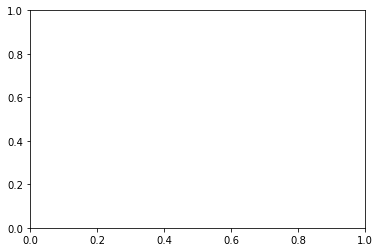

In [85]:
import matplotlib.pyplot as plt
# Show graph
limit=5; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, lp)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

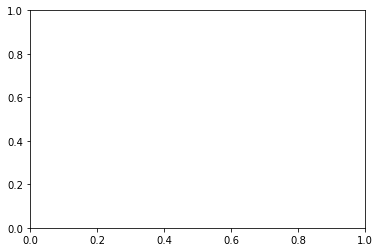

In [86]:
import matplotlib.pyplot as plt
# Show graph
limit=5; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, ll)
plt.xlabel("Num Topics")
plt.ylabel("Likelihood score")
plt.legend(("likelihood_values"), loc='best')
plt.show()

In [92]:
from pyspark.ml.clustering import LDA
lda = LDA(k=13, maxIter=20, optimizer="em")
model = lda.fit(corpus)

In [93]:
topicwords = 20
topics = model.describeTopics(topicwords)
topics.show(truncate=False)

+-----+---------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                                            |termWeights                                                                                                                                                                                                                                                                                                                                                     

In [94]:
tRDD = topics.rdd.map(list)
tRDD.collect()

[[0,
  [1268,
   3,
   1233,
   8,
   1249,
   5,
   2,
   20,
   10,
   1253,
   6,
   0,
   631,
   781,
   9,
   2032,
   899,
   14,
   11,
   38],
  [0.0023200809001227957,
   0.0021294106504046923,
   0.0020944544528803816,
   0.001973193408372298,
   0.0019343016531494011,
   0.0018838480479158222,
   0.001873296474245689,
   0.001820787234039871,
   0.001717999772591138,
   0.0017025356936583632,
   0.0016669936802951285,
   0.0016049440734001979,
   0.001595885102489325,
   0.001521927319722495,
   0.0015158717139204434,
   0.0014706335413162898,
   0.0014175366826511115,
   0.0013981962869264585,
   0.0013748240843350135,
   0.0013455009229827223]],
 [1,
  [6, 3, 8, 20, 10, 2, 25, 0, 5, 19, 12, 4, 38, 13, 9, 18, 32, 15, 104, 11],
  [0.0026335558373077202,
   0.002589807983239292,
   0.0025571736794442563,
   0.002432565528863526,
   0.002431046338831387,
   0.002299399804588606,
   0.0022548564269893006,
   0.002245254273507706,
   0.002185613289383803,
   0.00191950079416841

In [95]:
def topic_vocab(topic):
  print(topic)
  topicNum = topic[0]
  terms = topic[1]
  weight = topic[2]
  result = []
  for i in range(topicwords):
    term = vocab[terms[i]]
    out = str(topicNum)+","+term+","+str(weight[i])
    result.append(out)
  
  return result

In [96]:
tRDD.map(lambda topic: topic_vocab(topic)).collect()

[['0,genes,0.0023200809001227957',
  '0,data,0.0021294106504046923',
  '0,protein,0.0020944544528803816',
  '0,algorithm,0.001973193408372298',
  '0,gene,0.0019343016531494011',
  '0,model,0.0018838480479158222',
  '0,method,0.001873296474245689',
  '0,image,0.001820787234039871',
  '0,network,0.001717999772591138',
  '0,molecular,0.0017025356936583632',
  '0,system,0.0016669936802951285',
  '0,proposed,0.0016049440734001979',
  '0,expression,0.001595885102489325',
  '0,cells,0.001521927319722495',
  '0,using,0.0015158717139204434',
  '0,binding,0.0014706335413162898',
  '0,cancer,0.0014175366826511115',
  '0,different,0.0013981962869264585',
  '0,used,0.0013748240843350135',
  '0,energy,0.0013455009229827223'],
 ['1,system,0.0026335558373077202',
  '1,data,0.002589807983239292',
  '1,algorithm,0.0025571736794442563',
  '1,image,0.002432565528863526',
  '1,network,0.002431046338831387',
  '1,method,0.002299399804588606',
  '1,power,0.0022548564269893006',
  '1,proposed,0.00224525427350

In [97]:
topic = tRDD.map(lambda topic: topic_vacab(topic))
corpus.show(10)

+--------------------+
|            features|
+--------------------+
|(10000,[0,1,2,3,4...|
|(10000,[0,1,2,4,5...|
|(10000,[0,1,2,5,6...|
|(10000,[0,2,4,5,7...|
|(10000,[1,3,4,5,8...|
|(10000,[0,2,5,7,8...|
|(10000,[2,3,4,17,...|
|(10000,[0,1,3,7,1...|
|(10000,[5,7,13,16...|
|(10000,[0,1,4,5,1...|
+--------------------+
only showing top 10 rows



In [91]:
ng_pd = spark.createDataFrame(topic)
ng_pd.T

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 883.0 failed 4 times, most recent failure: Lost task 0.3 in stage 883.0 (TID 18822) (10.128.42.157 executor 2): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1560, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-90-a63054d2d33b>", line 1, in <lambda>
NameError: name 'topic_vacab' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:166)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1560, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-90-a63054d2d33b>", line 1, in <lambda>
NameError: name 'topic_vacab' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:166)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
